In [304]:
from os import getcwd
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Working directory
DIRPATH = getcwd() + r'\{}'
# Random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# Multiprocessing jobs (-1 to use all)
N_JOBS = -1

# Set plot formatting parameters
sns.set_context('paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] 

# Split and target labels to use throughout code
SPLIT_COL = 'Split'
TARGET_COL = 'Fup'
INTERNAL_TRAINING = 'Internal-Training'
INTERNAL_VALIDATION = 'Internal-Validation'
EXTERNAL_TEST = 'External-Test'

In [305]:
# Read PFAS identity and experimental Fup data from Fisher publication SI
pfas_file = DIRPATH.format('PFAS_QSAR_Supplemental.xlsx')
pfas_file_cols = ['Name_x', 'Name_y', 'Source', 'Fup_exp']
pfas_df = pd.concat([
    pd.read_excel(pfas_file, sheet_name = 'S1.Training.Set')[pfas_file_cols],
    pd.read_excel(pfas_file, sheet_name = 'S2.Test.Set')[pfas_file_cols]
]).rename(columns={'Name_x': 'DTXSID', 'Name_y': 'Chemical.Name', 'Fup_exp': 'Fup'})

# Read PFAS structure data from CompTox batch search
pfas_struct_cols = ['Chemical.Name', 'DTXSID', 'Mol_Structure', 'Fup']
pfas_struct = pd.read_csv(DIRPATH.format('CCD-Batch-Search_2025-03-04_01_26_30.csv'))
pfas_df = pfas_df.merge(pfas_struct, on='DTXSID').rename(columns = {'QSAR_READY_SMILES' : 'Mol_Structure'})[pfas_struct_cols]
pfas_df['Set'] = 'PFAS'

# Read OPERA and Dawson predictions for PFAS
dawson_cols = ['DTXSID', 'Chemical.Name', 'Mol_Structure', 'Set', 'Opera_LogP', 'Opera_LogWS', 'Opera_LogBCF', 'Opera_LogKM', 'Fup']
dawson_pfas = pd.read_csv(DIRPATH.format('Novel_fup_predictions_with_AD_Wetmore_descs_from_Opera2.6.csv')).rename(columns={'MoleculeID': 'DTXSID', 'Fup.RF.pred': 'DawsonPred'})
pfas_df = pfas_df.merge(dawson_pfas, on='DTXSID')[dawson_cols]

# Check results
print(pfas_df.shape)
pfas_df.head(10)

(114, 9)


,DTXSID,Chemical.Name,Mol_Structure,Set,Opera_LogP,Opera_LogWS,Opera_LogBCF,Opera_LogKM,Fup
0,DTXSID30627108,((Perfluorooctyl)ethyl)phosphonic acid,OP(O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,PFAS,1.281718,0.582556,-0.717885,0.971176,0.0070
1,DTXSID5061954,11-H-Perfluoroundecanoic acid,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,PFAS,1.221227,0.345205,0.343314,1.244207,0.0015
2,DTXSID60380390,"2,2,2-Trifluoroethyl perfluorobutanesulfonate",FC(F)(F)COS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,PFAS,0.569490,-0.860721,-0.989953,0.043431,0.0039
3,DTXSID20874028,"2H,2H,3H,3H-Perfluorooctanoic acid (5:3 FTCA)",OC(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,PFAS,0.364897,0.018958,-0.584784,0.329648,0.0059
4,DTXSID40380257,3-(Perfluoroisopropyl)-2-propenoic acid,OC(=O)C=CC(F)(C(F)(F)F)C(F)(F)F,PFAS,-0.131994,0.014103,-0.620829,-1.527835,0.1003
5,DTXSID00379268,3:3 Fluorotelomer carboxylic acid (3:3 FTCA),OC(=O)CCC(F)(F)C(F)(F)C(F)(F)F,PFAS,0.709144,-0.000514,-0.633265,-1.312759,0.0518
6,DTXSID80380256,"4,4-bis(Trifluoromethyl)-4-fluoropropanoic acid",OC(=O)CCC(F)(C(F)(F)F)C(F)(F)F,PFAS,0.686355,0.002344,-0.636760,-1.526155,0.0956
7,DTXSID50892417,4H-Perfluorobutanoic acid,OC(=O)C(F)(F)C(F)(F)C(F)F,PFAS,-0.488680,1.376294,-0.627299,-1.466912,0.1714
8,DTXSID90558000,6:2 Fluorotelomer phosphate monoester (6:2 mon...,OP(O)(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,PFAS,0.454052,0.643787,-0.851448,-0.030174,0.0058
9,DTXSID70165670,7H-Perfluoroheptanoic acid,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F,PFAS,0.202706,0.280397,-0.583701,-0.188776,0.0026


In [306]:
# Read original training and test sets from Dawson publication SI
dawson_file = DIRPATH.format('es0c06117_si_002.xlsx')
dawson_tr = pd.read_excel(dawson_file, sheet_name='S2.4. fup_Training_Sets', na_values='') # Read this separately because we need to check it for data leakage later
dawson_df = pd.concat([dawson_tr, pd.read_excel(dawson_file, sheet_name='S2.5. fup_Test_Sets', na_values='')])[dawson_cols]

# Check results
print(dawson_df.shape)
dawson_df.head(10)

(2057, 9)


,DTXSID,Chemical.Name,Mol_Structure,Set,Opera_LogP,Opera_LogWS,Opera_LogBCF,Opera_LogKM,Fup
0,DTXSID90873366,(-)-propranolol,CC(C)NCC(O)COC1=C2C=CC=CC2=CC=C1,ToxCast,0.418512,0.456563,0.172081,-0.087844,0.150000
1,DTXSID9047251,"(2s,3s)-n-[2-methoxy-5-(trifluoromethoxy)benzy...",COC1=C(CNC2CCCNC2C2=CC=CC=C2)C=C(OC(F)(F)F)C=C1,ToxCast,0.754786,-1.309221,0.836977,-1.013183,0.079959
2,DTXSID90241748,(r)-carvedilol,COC1=C(OCCNCC(O)COC2=CC=CC3=C2C2=C(N3)C=CC=C2)...,ToxCast,0.780311,-0.282629,-0.219251,0.095990,0.004500
3,DTXSID50241749,(s)-carvedilol,COC1=C(OCCNCC(O)COC2=CC=CC3=C2C2=C(N3)C=CC=C2)...,ToxCast,0.780311,-0.282629,-0.219251,0.095990,0.006300
4,DTXSID6035152,"1-(hydroxymethyl)-5,5-dimethylhydantoin",CC1(C)N(CO)C(=O)NC1=O,ToxCast,-1.173481,2.335102,-1.051814,-1.295649,0.921220
5,DTXSID2037712,"1,1,1-tris(p-hydroxyphenyl)ethane",CC(C1=CC=C(O)C=C1)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,ToxCast,0.367592,0.015810,0.754848,0.187806,0.014091
6,DTXSID7020687,"1,2,3,4,5,6-hexachlorocyclohexane",ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,ToxCast,0.561703,-1.056496,2.204005,2.881473,0.017424
7,DTXSID6020147,"1,2,3-benzotriazole",N1N=NC2=C1C=CC=C2,ToxCast,-0.678327,1.376328,-0.735699,-0.989488,0.287300
8,DTXSID8026193,"1,2,3-trichlorobenzene",ClC1=CC=CC(Cl)=C1Cl,ToxCast,0.758477,-0.397544,1.927793,2.324993,0.015667
9,DTXSID7024320,"1,2,4,5-tetrachlorobenzene",ClC1=CC(Cl)=C(Cl)C=C1Cl,ToxCast,1.063514,-0.945166,2.491133,2.911383,0.000993


In [307]:
# Combine PFAS and Dawson data
data = pd.concat([dawson_df, pfas_df])
# Read Mordred descriptors from file and add them to the data
descriptors = pd.read_csv(DIRPATH.format('Fup_Full_Datafile.csv')).iloc[:, np.r_[2, 11:908]].drop_duplicates(subset='Mol_Structure')
data = data.merge(descriptors, on='Mol_Structure')

# Keep the last entry when deduplicating, ensuring the new PFAS data
# overwrites any duplicate values that were in Dawson already
keep='last'
# Check whether DTXSID available for each record
mask_dtxsids = data['DTXSID'].isna()
# When DTXSIDs available, deduplicate by DTXSID
data_dtxsids = data[~mask_dtxsids]
data_dtxsids = data_dtxsids.drop_duplicates(subset='DTXSID', keep=keep)
# When DTXSIDs not available, deduplicate by chemical name
data_no_dtxsids = data[mask_dtxsids]
data_no_dtxsids = data_no_dtxsids.drop_duplicates(subset='Chemical.Name', keep=keep)
# Glue the data back together, then deduplicate anything that collapsed on QSAR-ready standardization using SMILES
# Deduplicating individual compounds by DTXSID or name is more reliable than SMILES, so this is the last resort
data = pd.concat([data_dtxsids, data_no_dtxsids]).drop_duplicates(subset='Mol_Structure', keep=keep).reset_index(drop=True)

# Check results
print(data.shape)
data.head(10)

(2089, 906)


,DTXSID,Chemical.Name,Mol_Structure,Set,Opera_LogP,Opera_LogWS,Opera_LogBCF,Opera_LogKM,Fup,nAcid,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,DTXSID9047251,"(2s,3s)-n-[2-methoxy-5-(trifluoromethoxy)benzy...",COC1=C(CNC2CCCNC2C2=CC=CC=C2)C=C(OC(F)(F)F)C=C1,ToxCast,0.754786,-1.309221,0.836977,-1.013183,7.995900e-02,0,...,0.000000,10.101887,61.934435,380.171163,7.603423,1962,39,138.0,157.0,5.958333
1,DTXSID6035152,"1-(hydroxymethyl)-5,5-dimethylhydantoin",CC1(C)N(CO)C(=O)NC1=O,ToxCast,-1.173481,2.335102,-1.051814,-1.295649,9.212200e-01,0,...,7.167809,9.467537,56.482818,158.069142,7.527102,137,17,56.0,67.0,2.444444
2,DTXSID2037712,"1,1,1-tris(p-hydroxyphenyl)ethane",CC(C1=CC=C(O)C=C1)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,ToxCast,0.367592,0.015810,0.754848,0.187806,1.409100e-02,0,...,0.000000,10.194327,57.718046,306.125594,7.466478,1108,39,122.0,145.0,5.000000
3,DTXSID6020147,"1,2,3-benzotriazole",N1N=NC2=C1C=CC=C2,ToxCast,-0.678327,1.376328,-0.735699,-0.989488,2.873000e-01,0,...,6.580639,8.914761,51.887188,119.048347,8.503453,79,9,46.0,53.0,2.027778
4,DTXSID8026193,"1,2,3-trichlorobenzene",ClC1=CC=CC(Cl)=C1Cl,ToxCast,0.758477,-0.397544,1.927793,2.324993,1.566700e-02,0,...,0.000000,8.876126,37.975562,179.930033,14.994169,82,11,42.0,47.0,2.055556
5,DTXSID7024320,"1,2,4,5-tetrachlorobenzene",ClC1=CC(Cl)=C(Cl)C=C1Cl,ToxCast,1.063514,-0.945166,2.491133,2.911383,9.930000e-04,0,...,0.000000,9.066585,39.732715,213.891061,17.824255,111,13,48.0,54.0,2.222222
6,DTXSID0021965,"1,2,4-trichlorobenzene",ClC1=CC(Cl)=C(Cl)C=C1,ToxCast,0.729829,-0.384270,2.060037,2.462761,5.272600e-07,0,...,0.000000,8.806724,37.839725,179.930033,14.994169,84,10,42.0,46.0,2.027778
7,DTXSID5032523,"1,2-benzisothiazolin-3-one",O=C1NSC2=C1C=CC=C2,ToxCast,-0.973652,0.289464,-0.719507,-1.209997,0.000000e+00,0,...,6.803505,9.141312,54.046679,151.009185,10.067279,106,12,52.0,61.0,2.222222
8,DTXSID7025132,"1,2-dimethyl-3-nitrobenzene",CC1=CC=CC(=C1C)[N+]([O-])=O,ToxCast,0.124324,0.594673,-0.382852,-0.848896,3.208700e-08,0,...,0.000000,9.148784,41.129752,151.063329,7.553166,146,15,52.0,59.0,2.500000
9,DTXSID4024066,"1,2-dinitrobenzene",[O-][N+](=O)C1=C(C=CC=C1)[N+]([O-])=O,ToxCast,-0.483380,0.167580,-0.501456,-0.976956,6.949400e-02,0,...,0.000000,9.178334,42.402582,168.017107,10.501069,188,16,56.0,63.0,2.750000


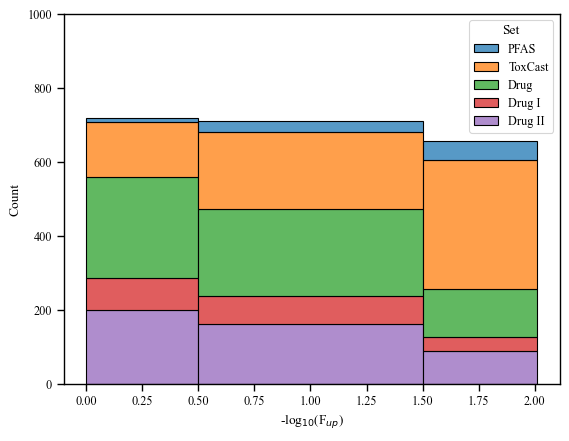

In [308]:
# Correct chemicals with Fup < LOD to LOD and chemicals with Fup > 1.0 to 1.0
data.loc[data[data[TARGET_COL] < 0.01].index, TARGET_COL] = 0.01
data.loc[data[data[TARGET_COL] > 1.0].index, TARGET_COL] = 1.0

# Define a negative log10 Fup column for stratification
data['negLog10_Fup'] = -np.log10(data[TARGET_COL])
bin_edges = [0, 0.5, 1.5, 2.01]
data['Fup_strat'] = np.digitize(data['negLog10_Fup'], bins=bin_edges)

# Split PFAS and non-PFAS data points
mask_pfas = data['Set'] == 'PFAS'
pfas_data = data[mask_pfas]
non_pfas_data = data[~mask_pfas]

# Plot endpoint distribution over all data
fig, ax = plt.subplots()
sns.histplot(data=data, x='negLog10_Fup', hue='Set', hue_order=['PFAS', 'ToxCast', 'Drug', 'Drug I', 'Drug II'], multiple='stack', bins=bin_edges, ax=ax)
ax.set_xlabel('-log$_{10}$(F$_{up}$)')
ax.set_ylim(0, 1000)
plt.show()

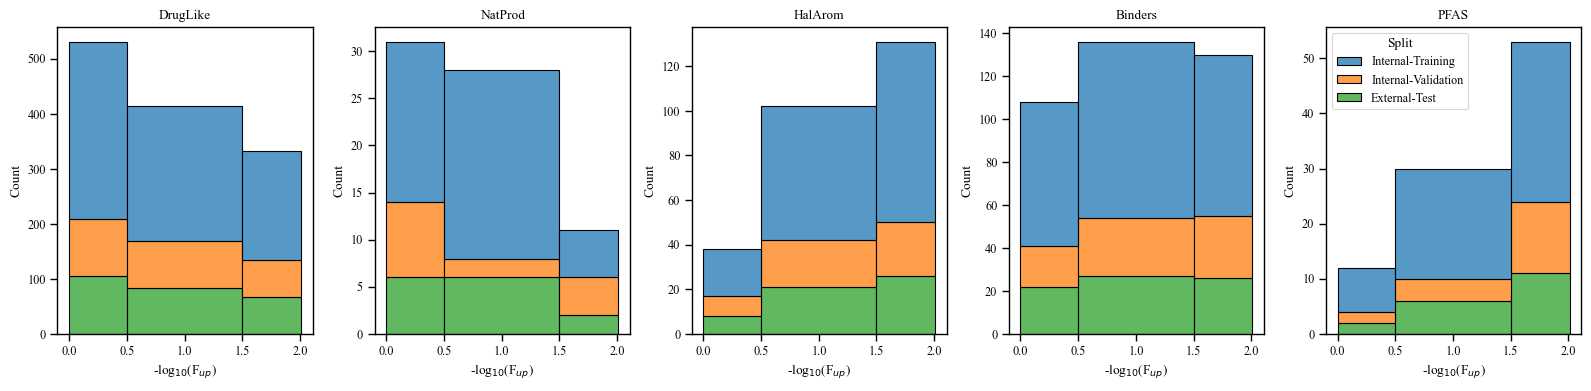

In [73]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Drop descriptors with zero variance (i.e. all the same value)
data.drop([desc for desc in data.columns if data[desc].nunique() == 1], axis=1, inplace=True)
# Define an embedding based on the Lipinski rules for absorption
cluster_embedding = ['nAtom', 'MW', 'AMW', 'nHBAcc', 'nHBDon', 'SLogP'] + [desc for desc in data.columns if desc.startswith('SlogP_VSA')]

# Set up feature scaling and clustering pipeline
n_clusters = 4
cluster_pipe = make_pipeline(StandardScaler(), AgglomerativeClustering(n_clusters=n_clusters))

# Derive structural clusters for non-PFAS compounds
non_pfas_data.loc[:, 'Cluster'] = cluster_pipe.fit_predict(non_pfas_data[cluster_embedding])
# Label PFAS as a separate cluster
pfas_data.loc[:, 'Cluster'] = n_clusters
data = pd.concat([non_pfas_data, pfas_data])

# Nickname clusters based on examination
cluster_names = ['DrugLike', 'NatProd', 'HalArom', 'Binders', 'PFAS']
data['Cluster'] = data['Cluster'].replace({i: name for (i, name) in enumerate(cluster_names)})
data.to_csv('clustered_data_final_041725.csv')

# Derive stratified splits for compounds on a per-cluster basis
# Generate histograms at the same time
fig, ax = plt.subplots(1, len(cluster_names), figsize=(16, 4))
for i, cl in enumerate(cluster_names):
    # Select cluster data
    cluster_data = data[data['Cluster'] == cl]
    # Internal-external stratified split
    X_cl_in, X_cl_ex, y_cl_in, y_cl_ex = train_test_split(cluster_data[cluster_embedding], cluster_data[TARGET_COL], test_size=0.2, random_state=SEED, stratify=cluster_data['Fup_strat'])
    data.loc[X_cl_ex.index, SPLIT_COL] = EXTERNAL_TEST
    # Internal training-validation split without stratification
    X_cl_tr, X_cl_val, y_cl_tr, y_cl_val = train_test_split(X_cl_in, y_cl_in, test_size=0.25, random_state=SEED)
    data.loc[X_cl_tr.index, SPLIT_COL] = INTERNAL_TRAINING
    data.loc[X_cl_val.index, SPLIT_COL] = INTERNAL_VALIDATION
    # Histogram
    sns.histplot(
        data=data[data['Cluster'] == cl], 
        x='negLog10_Fup', 
        hue='Split', 
        hue_order=[INTERNAL_TRAINING, INTERNAL_VALIDATION, EXTERNAL_TEST], 
        ax=ax[i], 
        multiple='stack', 
        bins=bin_edges,
        legend=(i == n_clusters)
    )
    ax[i].set_title(cl)
    ax[i].set_xlabel('-log$_{10}$(F$_{up}$)')

fig.tight_layout()
plt.show()

c:\Users\gsincl01\OneDrive - Environmental Protection Agency (EPA)\Profile\Documents\Projects\2025 Fup\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gsincl01\OneDrive - Environmental Protection Agency (EPA)\Profile\Documents\Projects\2025 Fup\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


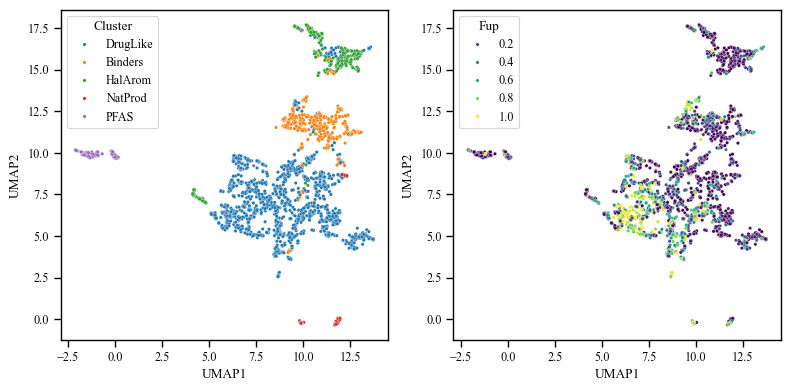

In [369]:
import umap

umap_embedding = cluster_embedding

umap_pipe = make_pipeline(StandardScaler(), umap.UMAP(random_state=SEED))
vis_df = pd.concat([
    pd.DataFrame(umap_pipe.fit_transform(data[umap_embedding]), index=data.index, columns=['UMAP1', 'UMAP2']),
    data[['Set', 'Split', 'Fup', 'Cluster', 'Mol_Structure']]
], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=vis_df, x='UMAP1', y='UMAP2', hue='Cluster', s=6, ax=ax[0])
sns.scatterplot(data=vis_df, x='UMAP1', y='UMAP2', hue='Fup', palette='viridis', s=6, ax=ax[1])
fig.tight_layout()
plt.show()

991 training points / 331 validation points
Training on core data...


Training: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]

Best validation performance: MSE = 0.04 / RMSE = 0.21


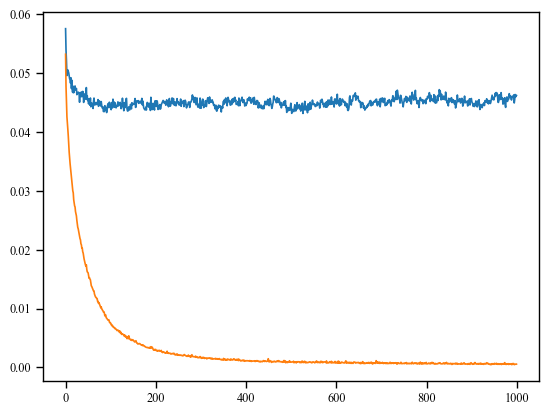

In [ ]:
import collections
import tqdm

from copy import deepcopy

# Perform a single epoch of model training
def train_epoch(model, loss_func, optim, X_tr, y_tr, batch_size):
    # Model in training mode
    model.train()
    # Loop over batches
    for j in torch.arange(0, len(y_tr), batch_size):
        X_bat = X_tr[j:(j + batch_size)]
        y_bat = y_tr[j:(j + batch_size)]
        # Forward pass
        y_pred = model(X_bat)
        loss = loss_func(y_bat, y_pred)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        # Update weights
        optim.step()

    # Return the trained model
    return model

# Model training loop with custom loss, Adam optimizer, learning rate decay after the null model equivalent loss is reached, and optional layer freezing
def train_loop(model, n_epochs, loss_func, lr, lr_decay_factor, X_tr, y_tr, X_val, y_val, batch_size, freeze_layers=None):
    # Hold the best model and track score history
    best_loss = np.inf
    best_weights = None
    history = []
    history_tr = []

    # Define the optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    decayed = False

    # Calculate the equivalent loss from a null model (mean of training set)
    null_preds = np.array([torch.mean(y_tr)] * len(y_val)).reshape(-1, 1)
    null_loss = float(loss_func(y_val, torch.tensor(null_preds, dtype=torch.float32)))

    # Loop over training epochs
    for i in tqdm.tqdm(range(n_epochs), desc='Training'):
        # If loss <= null model equivalent loss, implement learning rate decay
        if best_loss <= null_loss and not decayed:
            optim = torch.optim.Adam(model.parameters(), lr=lr / lr_decay_factor)
            decayed = True

        # Do an epoch of training
        model = train_epoch(model, loss_func, optim, X_tr, y_tr, batch_size)

        # Model in evaluation mode
        model.eval()
        # Calculate validation score
        loss = float(loss_func(y_val, model(X_val)))
        # If better than best previous epoch, save model params
        if loss < best_loss:
            best_loss = loss
            best_weights = deepcopy(model.state_dict())
        
        # Save score history for training curves
        history.append(loss)
        history_tr.append(float(loss_func(y_tr, model(X_tr))))

    # Load the best model state
    model.load_state_dict(best_weights)

    # Freeze layers if instructed
    if freeze_layers:
        for name, layer in model.named_children():
            if name in freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False

    return model, best_loss, history, history_tr, best_weights

# Split data and convert to tensors for neural network training and validation
def split_data_to_tensors(data, embedding, scaler, fit_scaler=False, dtype=torch.float32):
    data_tr = data[data[SPLIT_COL] == INTERNAL_TRAINING]
    data_val = data[data[SPLIT_COL] == INTERNAL_VALIDATION]
    X_tr = torch.tensor(scaler.fit_transform(data_tr[embedding]) if fit_scaler else scaler.transform(data_tr[embedding]), dtype=dtype)
    y_tr = torch.tensor(data_tr[TARGET_COL].to_numpy().reshape(-1, 1), dtype=dtype)
    X_val = torch.tensor(scaler.transform(data_val[embedding]), dtype=dtype)
    y_val = torch.tensor(data_val[TARGET_COL].to_numpy().reshape(-1, 1), dtype=dtype)
    return X_tr, y_tr, X_val, y_val

# Define embedding using VSA and autocorrelation descriptors
embedding = cluster_embedding + [desc for desc in data.columns if ('VSA' in desc and not 'SlogP' in desc) or 'AATSC' in desc]

# Feed-forward neural network architecture
dropout_p = 0.2
feature_coef = 1
n_features_init = len(embedding)
n_features_hidden = int(n_features_init / feature_coef)
n_features_penult = int(n_features_hidden / feature_coef)
model = torch.nn.Sequential(
    collections.OrderedDict(
        [
            ('linear1', torch.nn.Linear(n_features_init, n_features_hidden)),
            ('relu1', torch.nn.ReLU()),
            ('dropout1', torch.nn.Dropout(p=dropout_p)),
            ('linear2', torch.nn.Linear(n_features_hidden, n_features_hidden)),
            ('relu2', torch.nn.ReLU()),
            ('dropout2', torch.nn.Dropout(p=dropout_p)),
            ('linear3', torch.nn.Linear(n_features_hidden, n_features_hidden)),
            ('relu3', torch.nn.ReLU()),
            ('linear4', torch.nn.Linear(n_features_hidden, n_features_penult)),
            ('relu4', torch.nn.ReLU()),
            ('linear5', torch.nn.Linear(n_features_penult, 1)),
            ('relu5', torch.nn.ReLU())
        ]
    )
)

# Model training parameters
n_epochs_core = 1000
loss_func = torch.nn.MSELoss()
core_lr = 0.0005
core_lr_decay_factor = 10
core_batch_size = 4
freeze_layers = ['linear1', 'linear2']

# Select and standardize core data
scaler = StandardScaler()
core_clusters = ['DrugLike', 'Binders']
core_data = data[data['Cluster'].isin(core_clusters)]
X_core_tr, y_core_tr, X_core_val, y_core_val = split_data_to_tensors(
    core_data, embedding, scaler, fit_scaler=True
)
print(f'{len(y_core_tr)} training points / {len(y_core_val)} validation points')

# Train the core model
print(f'Training on core data...')
model, core_best_loss, core_history, core_history_tr, core_best_weights = train_loop(
    model, n_epochs_core, loss_func, core_lr, core_lr_decay_factor, X_core_tr, y_core_tr, X_core_val, y_core_val, core_batch_size, freeze_layers
)

# Store core model predictions for all splits
data['Fup_Core'] = model(torch.tensor(scaler.transform(data[embedding]), dtype=torch.float32)).detach()

# Output the best performance
print(f'Best validation performance: MSE = {core_best_loss:.2f} / RMSE = {np.sqrt(core_best_loss):.2f}')

# Plot the core training curves
fig, ax = plt.subplots()
ax.plot(core_history, label='Validation')
ax.plot(core_history_tr, label='Training')
plt.show()

Fine-tuning on NatProd...
42 training points / 14 validation points


Training: 100%|██████████| 3000/3000 [02:20<00:00, 21.29it/s]


Best validation performance: MSE = 0.11 / RMSE = 0.34


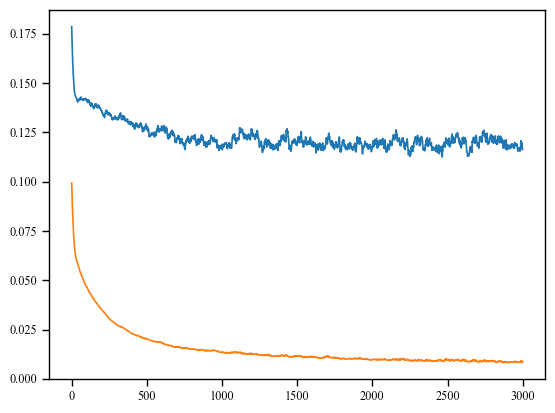

Fine-tuning on HalArom...
162 training points / 54 validation points


Training: 100%|██████████| 3000/3000 [09:12<00:00,  5.43it/s]


Best validation performance: MSE = 0.03 / RMSE = 0.18


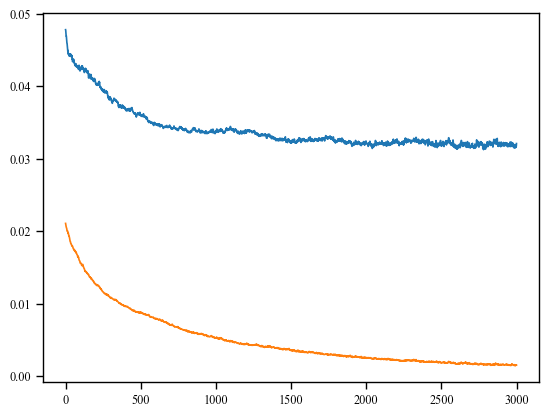

Fine-tuning on PFAS...
57 training points / 19 validation points


Training: 100%|██████████| 3000/3000 [03:29<00:00, 14.29it/s]


Best validation performance: MSE = 0.04 / RMSE = 0.19


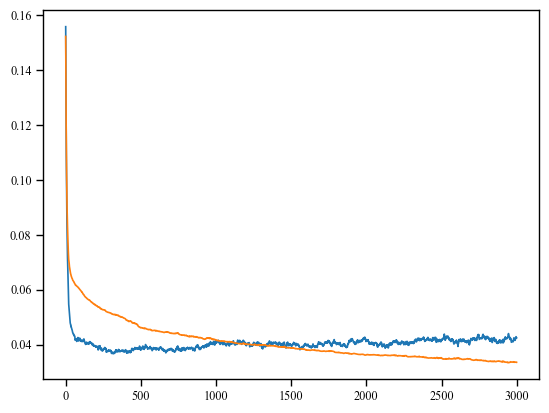

In [ ]:
# Fine-tuning training parameters
n_epochs_tuning = 3000
tuning_lr = 0.00001
tuning_lr_decay_factor = 1 # No learning decay on fine-tuning
tuning_batch_size = 1

model_names = ['Fup_Core']

# Perform fine-tuning on every non-core cluster
for i, cl in enumerate(cluster_names):
    # Skip core clusters
    if cl in core_clusters:
        continue

    model_name = f'Fup_{cl}'
    model_names.append(model_name)

    # Reinitialize core model on every fine-tuning round
    model.load_state_dict(core_best_weights)

    # Select and standardize fine-tuning data
    tuning_data = data[data['Cluster'] == cl]
    X_tuning_tr, y_tuning_tr, X_tuning_val, y_tuning_val = split_data_to_tensors(tuning_data, embedding, scaler)
    print(f'Fine-tuning on {cl}...')
    print(f'{len(y_tuning_tr)} training points / {len(y_tuning_val)} validation points')

    # Fine-tune the model
    model, tuning_best_loss, tuning_history, tuning_history_tr, _ = train_loop(
        model, n_epochs_tuning, loss_func, tuning_lr, tuning_lr_decay_factor, X_tuning_tr, y_tuning_tr, X_tuning_val, y_tuning_val, tuning_batch_size
    )

    # Store tuned model predictions for all splits
    data[model_name] = model(torch.tensor(scaler.transform(data[embedding]), dtype=torch.float32)).detach()

    # Output the best performance
    print(f'Best validation performance: MSE = {tuning_best_loss:.2f} / RMSE = {np.sqrt(tuning_best_loss):.2f}')

    # Plot the training curves
    fig, ax = plt.subplots()
    ax.plot(tuning_history, label='Validation')
    ax.plot(tuning_history_tr, label='Training')
    plt.show()

In [ ]:
# Correct any predictions > 1.0 to 1.0
for mod in model_names:
    data.loc[data[data[mod] > 1.0].index, mod] = 1.0
# Save all predictions
data.to_csv(DIRPATH.format('pred_data_final_041725.csv'))

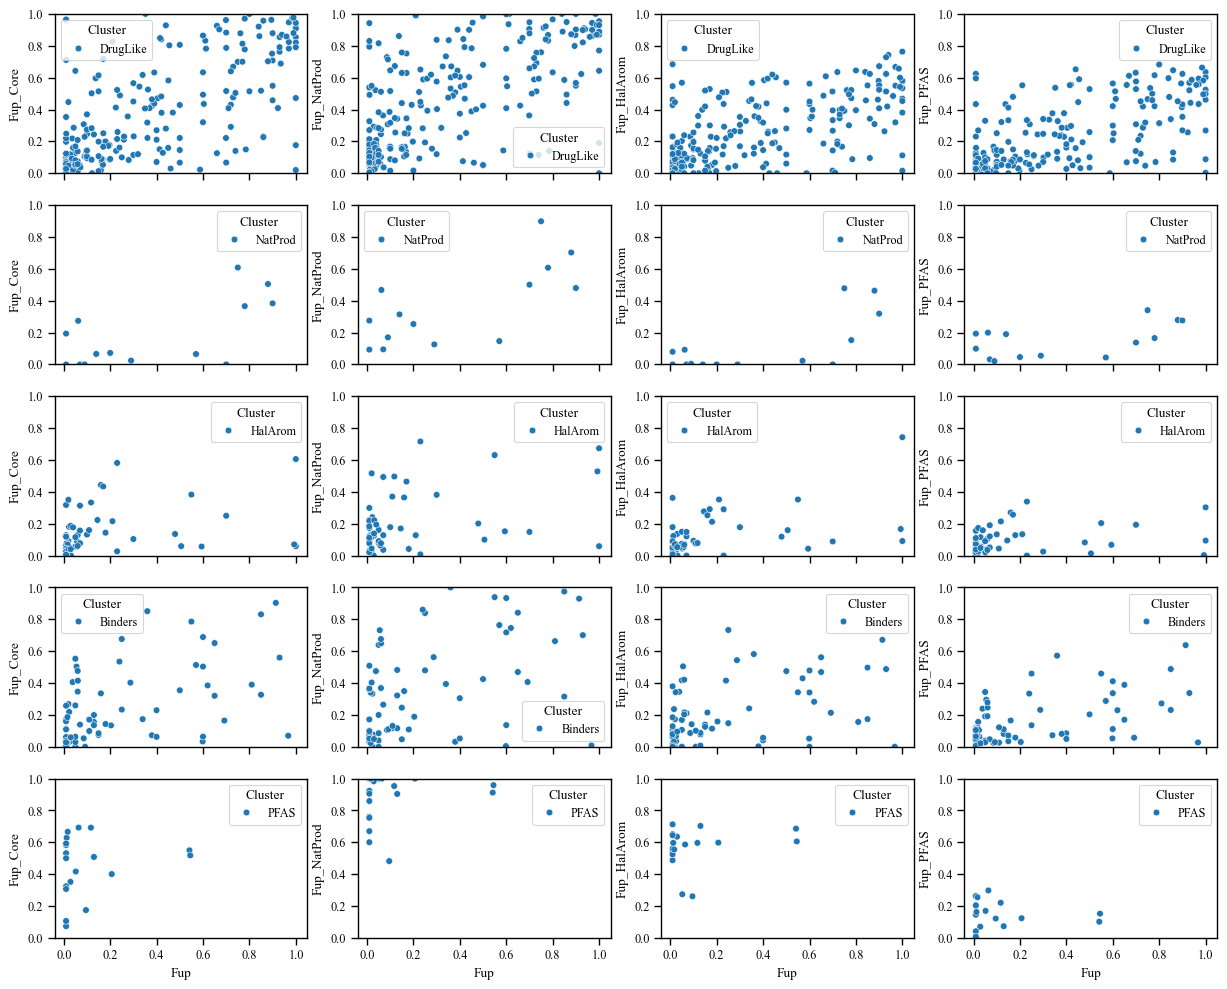

In [ ]:
# Plot matrix of external test data vs. predictions
data_ex = data[data[SPLIT_COL] == EXTERNAL_TEST]
fig, ax = plt.subplots(len(cluster_names), len(model_names), figsize=(15, 12), sharex=True)

for i, cl in enumerate(cluster_names):
    cluster_data_ex = data_ex[data_ex['Cluster'] == cl]
    for j, mod in enumerate(model_names):
        sns.scatterplot(data=cluster_data_ex, x='Fup', y=mod, hue='Cluster', ax=ax[i, j])
        ax[i, j].set_ylim(0, 1)

plt.show()

In [248]:
import sklearn.metrics as metrics

# Naive boostrap implementation for the difference in a score statistic from the core model
# This could definitely be made more efficient but it's fine for now
def bootstrap_stat(df, true_col, pred_col, stat_func, quantiles, n_reps=1000):
    stats = [None] * n_reps
    for n in range(n_reps):
        sp = df.sample(frac=1.0, replace=True)
        stats[n] = stat_func(sp[true_col], sp[pred_col])
    return np.quantile(stats, quantiles)

def bootstrap_stat_diff(df, true_col, pred_col, ref_pred_col, stat_func, quantiles, n_reps=1000):
    stats = [None] * n_reps
    for n in range(n_reps):
        sp = df.sample(frac=1.0, replace=True)
        stats[n] = stat_func(sp[true_col], sp[pred_col]) - stat_func(sp[true_col], sp[ref_pred_col])
    return np.quantile(stats, quantiles)

quantiles = [0.025, 0.5, 0.975]
grouped = data_ex.groupby('Cluster')

stats = []
for mod in model_names:
    rmse = grouped.apply(lambda x: bootstrap_stat(x, TARGET_COL, mod, metrics.root_mean_squared_error, quantiles), include_groups=False)
    stats.append(rmse)

bootstrap_stats_df = pd.DataFrame(stats, index=model_names).explode(cluster_names)
bootstrap_stats_df['Quantile'] = quantiles * len(model_names)
bootstrap_stats_df

Cluster,Binders,DrugLike,HalArom,NatProd,PFAS,Quantile
Fup_Core,0.193862,0.206203,0.162524,0.206781,0.333363,0.025
Fup_Core,0.248154,0.24244,0.2475,0.330001,0.419057,0.500
Fup_Core,0.300858,0.278609,0.338692,0.438292,0.492159,0.975
Fup_HalArom,0.20616,0.239288,0.141783,0.238667,0.436603,0.025
Fup_HalArom,0.263839,0.269042,0.226539,0.366528,0.500358,0.500
Fup_HalArom,0.324331,0.300724,0.309853,0.478453,0.557922,0.975
Fup_NatProd,0.245263,0.240925,0.181976,0.159405,0.715914,0.025
Fup_NatProd,0.300789,0.274393,0.248794,0.234421,0.802178,0.500
Fup_NatProd,0.359436,0.305373,0.325974,0.306776,0.87311,0.975
Fup_PFAS,0.195566,0.242917,0.159982,0.260383,0.123251,0.025


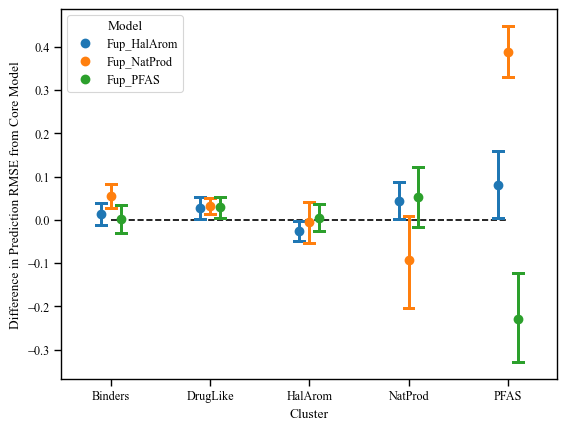

In [ ]:
# Boostrap median and 95% CI for difference of RMSE of all models on all clusters compared to RMSE of core model
stats_diff = []
for mod in model_names:
    rmse = grouped.apply(lambda x: bootstrap_stat_diff(x, TARGET_COL, mod, 'Fup_Core', metrics.root_mean_squared_error, quantiles), include_groups=False)
    stats_diff.append(rmse)

bootstrap_diff_stats_df = pd.DataFrame(stats_diff, index=model_names).explode(cluster_names)
bootstrap_diff_stats_df['Quantile'] = quantiles * len(model_names)
plot_bs_diff_stats_df = bootstrap_diff_stats_df.melt(ignore_index=False, id_vars=['Quantile']).reset_index().rename(columns={'index': 'Model', 'value': 'RMSE_diff'})

fig, ax = plt.subplots()
sns.lineplot(x=[0.0, 4.0], y=[0.0, 0.0], color='black', linestyle='--', ax=ax)
sns.pointplot(data=plot_bs_diff_stats_df[plot_bs_diff_stats_df['Model'] != 'Fup_Core'], x='Cluster', y='RMSE_diff', hue='Model', dodge=0.2, errorbar=('pi', 100), linestyle='none', capsize=0.1)
ax.set_ylabel('Difference in Prediction RMSE from Core Model')
plt.show()

C:\Users\gsincl01\AppData\Local\Temp\ipykernel_6520\2114048790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfas_fig_data['Cluster'] = pfas_fig_data['Cluster'].replace({'Binders': 'Core', 'DrugLike': 'Core'})


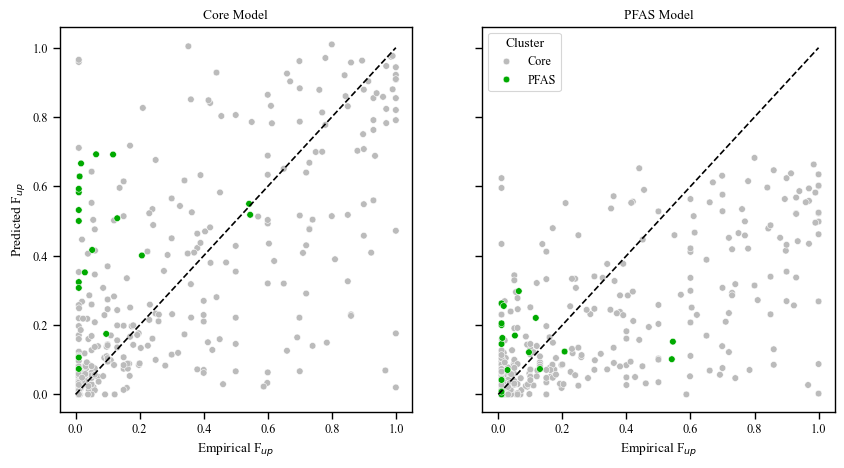

In [ ]:
# Plot PFAS cluster model results
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
pfas_fig_data = data_ex[data_ex['Cluster'].isin(['DrugLike', 'Binders', 'PFAS'])]
pfas_fig_data['Cluster'] = pfas_fig_data['Cluster'].replace({k: 'Core' for k in core_clusters})
sns.scatterplot(data=pfas_fig_data, x='Fup', y='Fup_Core', hue='Cluster', palette=['#BBBBBB', '#00AA00'], ax=ax[0], legend=False)
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[0])
ax[0].set_title('Core Model')
ax[0].set_ylabel('Predicted F$_{up}$')
ax[0].set_xlabel('Empirical F$_{up}$')
sns.scatterplot(data=pfas_fig_data, x='Fup', y='Fup_PFAS', hue='Cluster', palette=['#BBBBBB', '#00AA00'], ax=ax[1])
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[1])
ax[1].set_title('PFAS Model')
ax[1].set_xlabel('Empirical F$_{up}$')
ax[1].legend(title='Cluster')
plt.show()

In [ ]:
# Calculate trivial model RMSE for PFAS cluster
y_ex_pfas = pfas_fig_data[pfas_fig_data['Cluster'] == 'PFAS']['Fup']
print(metrics.root_mean_squared_error(y_ex_pfas, [0.01] * len(y_ex_pfas)))

0.18439961215125591


C:\Users\gsincl01\AppData\Local\Temp\ipykernel_6520\693619158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np_fig_data['Cluster'] = np_fig_data['Cluster'].replace({'Binders': 'Core', 'DrugLike': 'Core'})


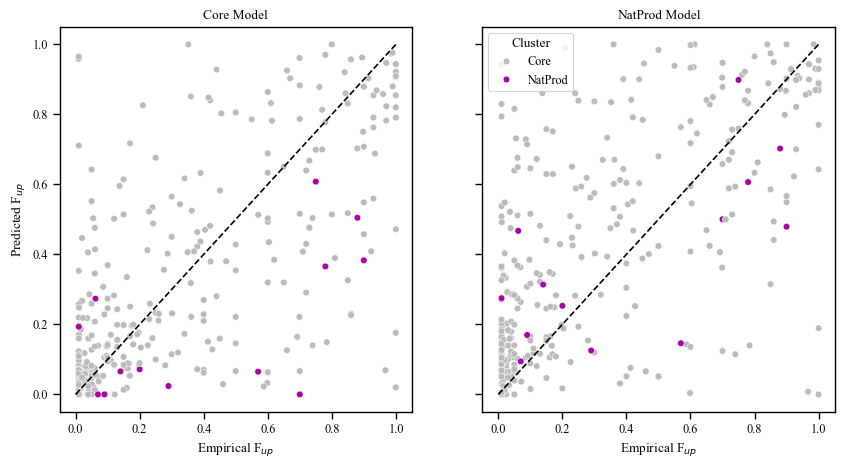

In [ ]:
# Plot NatProd cluster model results
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
np_fig_data = data_ex[data_ex['Cluster'].isin(['DrugLike', 'Binders', 'NatProd'])]
np_fig_data['Cluster'] = np_fig_data['Cluster'].replace({k: 'Core' for k in core_clusters})
sns.scatterplot(data=np_fig_data, x='Fup', y='Fup_Core', hue='Cluster', palette=['#BBBBBB', '#AA00AA'], ax=ax[0], legend=False)
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[0])
ax[0].set_title('Core Model')
ax[0].set_ylabel('Predicted F$_{up}$')
ax[0].set_xlabel('Empirical F$_{up}$')
sns.scatterplot(data=np_fig_data, x='Fup', y='Fup_NatProd', hue='Cluster', palette=['#BBBBBB', '#AA00AA'], ax=ax[1])
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[1])
ax[1].set_title('NatProd Model')
ax[1].set_xlabel('Empirical F$_{up}$')
ax[1].legend(title='Cluster')
plt.show()

In [329]:
# Calculate trivial model RMSE for NatProd cluster
data_in = data[data[SPLIT_COL] != EXTERNAL_TEST]
y_ex_np = np_fig_data[np_fig_data['Cluster'] == 'NatProd']['Fup']
print(metrics.root_mean_squared_error(y_ex_np, [0.01] * len(y_ex_np)))
print(metrics.root_mean_squared_error(y_ex_np, [1.0] * len(y_ex_np)))
print(metrics.root_mean_squared_error(y_ex_np, [np.mean(data_in['Fup'])] * len(y_ex_np)))

0.5087311948086422
0.698311432773986
0.35613714290113674


In [354]:
# data = pd.read_csv('pred_data_final_041725.csv')

# Select the Dawson and comparison model predictions for the PFAS external set
dawson_pfas_ex = dawson_pfas[['DTXSID', 'Outlier', 'DawsonPred']].merge(data[['Cluster', 'Split', 'DTXSID', TARGET_COL, 'Fup_PFAS']], on='DTXSID').query(f'Split == \'{EXTERNAL_TEST}\'')
dawson_prox = pd.read_csv(DIRPATH.format('Reproducing Dawson/wetmore_dawson_fup_pred_with_prox.csv'))[['Name', 'neighbor_dtxsid', 'neighbor_name', 'neighbor_prox']].rename(columns={'Name': 'DTXSID'})
dawson_pfas_ex = dawson_pfas_ex.merge(dawson_prox, on='DTXSID')

dawson_pfas_ex.loc[dawson_pfas_ex['DawsonPred'] < 0.01, 'DawsonPred'] = 0.01
dawson_pfas_ex.loc[dawson_pfas_ex['DawsonPred'] > 1.0, 'DawsonPred'] = 1.0

dawson_pfas_ex.sort_values('neighbor_prox', inplace=True)

# Check results (N should = 19)
print(dawson_pfas_ex.shape)
dawson_pfas_ex.head(19)

(19, 10)


,DTXSID,Outlier,DawsonPred,Cluster,Split,Fup,Fup_PFAS,neighbor_dtxsid,neighbor_name,neighbor_prox
4,DTXSID60377821,0,0.051833,PFAS,External-Test,0.064000,0.298011,DTXSID5034303,fluroxypyr-meptyl,0.072
16,DTXSID80380256,1,0.091709,PFAS,External-Test,0.095600,0.121645,DTXSID2032502,triflusulfuron-methyl,0.082
5,DTXSID7060332,0,0.028023,PFAS,External-Test,0.010000,0.205057,DTXSID8057695,floctafenine,0.084
0,DTXSID70381090,1,0.254004,PFAS,External-Test,0.206936,0.123603,DTXSID6040668,dipyridamole,0.090
7,DTXSID00379268,1,0.091702,PFAS,External-Test,0.051800,0.169795,DTXSID2032502,triflusulfuron-methyl,0.094
2,DTXSID40379666,0,0.053516,PFAS,External-Test,0.545074,0.152161,DTXSID6047286,candoxatril,0.104
1,DTXSID70366226,1,0.173895,PFAS,External-Test,0.541715,0.101599,DTXSID3037707,potassium nonafluoro-1-butanesulfonate,0.110
13,DTXSID4059833,1,0.100188,PFAS,External-Test,0.117000,0.220658,DTXSID3031862,perfluorohexanoic acid,0.118
10,DTXSID20375106,1,0.148075,PFAS,External-Test,0.010000,0.145409,DTXSID3037707,potassium nonafluoro-1-butanesulfonate,0.118
17,DTXSID80380837,1,0.058967,PFAS,External-Test,0.010000,0.262590,DTXSID8047553,perfluoroundecanoic acid,0.148


In [355]:
# Identify any of the PFAS external set that appeared in the Dawson model training data
dawson_leak_mask = dawson_pfas_ex['DTXSID'].isin(dawson_tr['DTXSID'])
dawson_pfas_ex[dawson_leak_mask]

,DTXSID,Outlier,DawsonPred,Cluster,Split,Fup,Fup_PFAS,neighbor_dtxsid,neighbor_name,neighbor_prox
12,DTXSID3031860,1,0.01,PFAS,External-Test,0.0100,0.009525,DTXSID8047553,perfluoroundecanoic acid,0.592
15,DTXSID8031863,1,0.01,PFAS,External-Test,0.0100,0.041727,DTXSID8031863,perfluorononanoic acid,0.654
9,DTXSID1032646,1,0.01,PFAS,External-Test,0.0289,0.070425,DTXSID1032646,sulfluramid,0.720


In [356]:
# Exclude any points that appeared in the training set
dawson_pfas_ex = dawson_pfas_ex[~dawson_leak_mask]
# Output the RMSE
print(metrics.root_mean_squared_error(dawson_pfas_ex[TARGET_COL], dawson_pfas_ex['DawsonPred']))

0.162313933058523


In [327]:
# Bootstrap statistics on Dawson model, PFAS cluster tuned model, and difference of the two
print(bootstrap_stat(dawson_pfas_ex, TARGET_COL, 'DawsonPred', metrics.root_mean_squared_error, quantiles))
print(bootstrap_stat(dawson_pfas_ex, TARGET_COL, 'Fup_PFAS', metrics.root_mean_squared_error, quantiles))
print(bootstrap_stat_diff(dawson_pfas_ex, TARGET_COL, 'DawsonPred', 'Fup_PFAS', metrics.root_mean_squared_error, quantiles))

[0.04575054 0.15840217 0.25577254]
[0.13227567 0.20364371 0.26650803]
[-0.11736288 -0.04574071  0.0085618 ]


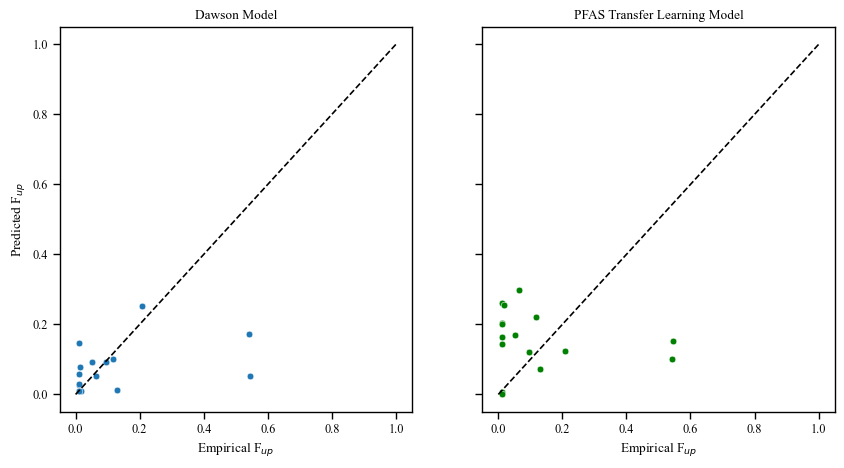

In [362]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(data=dawson_pfas_ex, x='Fup', y='DawsonPred', ax=ax[0])
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[0])
ax[0].set_ylabel('Predicted F$_{up}$')
ax[0].set_xlabel('Empirical F$_{up}$')
ax[0].set_title('Dawson Model')
sns.scatterplot(data=dawson_pfas_ex, x='Fup', y='Fup_PFAS', color='green', ax=ax[1])
sns.lineplot(x=[0.0, 1.0], y=[0.0, 1.0], color='black', linestyle='--', ax=ax[1])
ax[1].set_ylabel('Predicted F$_{up}$')
ax[1].set_xlabel('Empirical F$_{up}$')
ax[1].set_title('PFAS Transfer Learning Model')
plt.show()

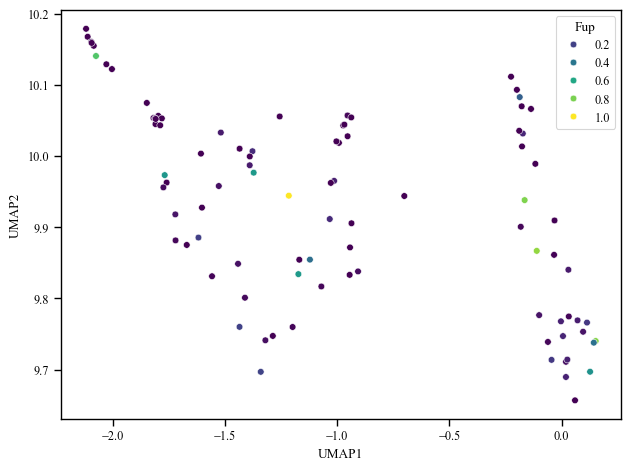

In [364]:
pfas_vis_df = vis_df[(vis_df['Cluster'] == 'PFAS') & (vis_df['UMAP1'] < 2)]

fig, ax = plt.subplots()
sns.scatterplot(data=pfas_vis_df, x='UMAP1', y='UMAP2', hue='Fup', palette='viridis')
fig.tight_layout()
plt.show()

In [430]:
from scipy.spatial.distance import pdist, squareform

pfas_data = data.loc[data[data['Cluster'] == 'PFAS'].index, cluster_embedding + ['Fup_strat', 'DTXSID']].set_index('DTXSID')
pfas_loose_mask = pfas_data['Fup_strat'] == 1
pfas_loose_idx = pfas_data[pfas_loose_mask].index
pfas_tight_idx = pfas_data[~pfas_loose_mask].index

pfas_lib = pd.concat([pfas_data[cluster_embedding], pd.read_csv('PFAS_library_Full_Datafile.csv').set_index('DTXSID')[cluster_embedding]])
pfas_lib = pfas_lib[~pfas_lib.index.duplicated(keep='first')]
dist = pd.DataFrame(squareform(pdist(StandardScaler().fit_transform(pfas_lib))), index=pfas_lib.index, columns=pfas_lib.index)
pfas_loose_rad = dist.loc[pfas_loose_idx, pfas_tight_idx].min(axis=1)

new_pfas_dist = dist.loc[~dist.index.isin(pfas_data.index), pfas_loose_idx]
new_loose_pfas = new_pfas_dist.loc[new_pfas_dist.le(pfas_loose_rad).any(axis=1), :]
new_loose_pfas.to_csv('potential_loose_pfas_042325.csv')

print(new_loose_pfas.shape)
new_loose_pfas.head(10)

(453, 12)


DTXSID,DTXSID8059926,DTXSID70880230,DTXSID2060965,DTXSID70366226,DTXSID80310730,DTXSID4059914,DTXSID40379666,DTXSID0059871,DTXSID10382147,DTXSID80382093,DTXSID0060985,DTXSID8059928
DTXSID,,,,,,,,,,,,
DTXSID20896563,2.285303,1.978803,6.958173,2.605378,2.701439,2.903379,1.527387,0.649566,0.787107,1.335774,2.288423,3.154626
DTXSID20896588,2.136114,2.781633,7.122347,2.108740,3.114021,3.235612,1.307324,1.639012,1.126895,0.277817,2.950301,2.112724
DTXSID20896604,2.136114,2.781633,7.122347,2.108740,3.114021,3.235612,1.307324,1.639012,1.126895,0.277817,2.950301,2.112724
DTXSID20896649,2.136114,2.781633,7.122347,2.108740,3.114021,3.235612,1.307324,1.639012,1.126895,0.277817,2.950301,2.112724
DTXSID20897050,1.853632,3.805564,7.530930,2.648707,4.503616,4.508834,2.075839,2.907479,1.983535,1.705473,4.318518,0.833971
DTXSID20897550,5.837113,5.743320,5.680953,4.785532,5.838670,5.604457,5.201567,5.542069,5.458460,5.414786,5.947158,5.790264
DTXSID20904576,4.382992,3.375678,5.758475,3.693889,2.749454,3.102772,3.625499,2.927402,3.357989,3.501174,3.165351,5.100171
DTXSID20904753,5.479883,5.379923,5.681077,4.966511,5.838569,5.691331,5.205645,5.301536,5.211377,5.410859,5.712578,5.930937
DTXSID20905402,3.954394,1.854003,7.329172,2.914209,1.842722,1.185885,2.917091,2.396666,3.046183,3.171222,1.820433,4.920534
